# Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("../input/bike-sharing-demand/train.csv", parse_dates=["datetime"])
df_test = pd.read_csv("../input/bike-sharing-demand/test.csv", parse_dates=["datetime"])

print(df_train.shape)
print(df_test.shape)

(10886, 12)
(6493, 9)


# Feature Engineering

In [3]:
df_train["year"] = df_train["datetime"].dt.year
df_train["month"] = df_train["datetime"].dt.month
df_train["day"] = df_train["datetime"].dt.day
df_train["hour"] = df_train["datetime"].dt.hour
df_train["minute"] = df_train["datetime"].dt.minute
df_train["second"] = df_train["datetime"].dt.second
df_train["weekday"] = df_train["datetime"].dt.dayofweek

df_train.shape

(10886, 19)

In [4]:
df_test["year"] = df_test["datetime"].dt.year
df_test["month"] = df_test["datetime"].dt.month
df_test["day"] = df_test["datetime"].dt.day
df_test["hour"] = df_test["datetime"].dt.hour
df_test["minute"] = df_test["datetime"].dt.minute
df_test["second"] = df_test["datetime"].dt.second
df_test["weekday"] = df_test["datetime"].dt.dayofweek

df_test.shape

(6493, 16)

#### 풍속 데이터 확인하기

<AxesSubplot:title={'center':'test Windspeed'}, xlabel='windspeed', ylabel='count'>

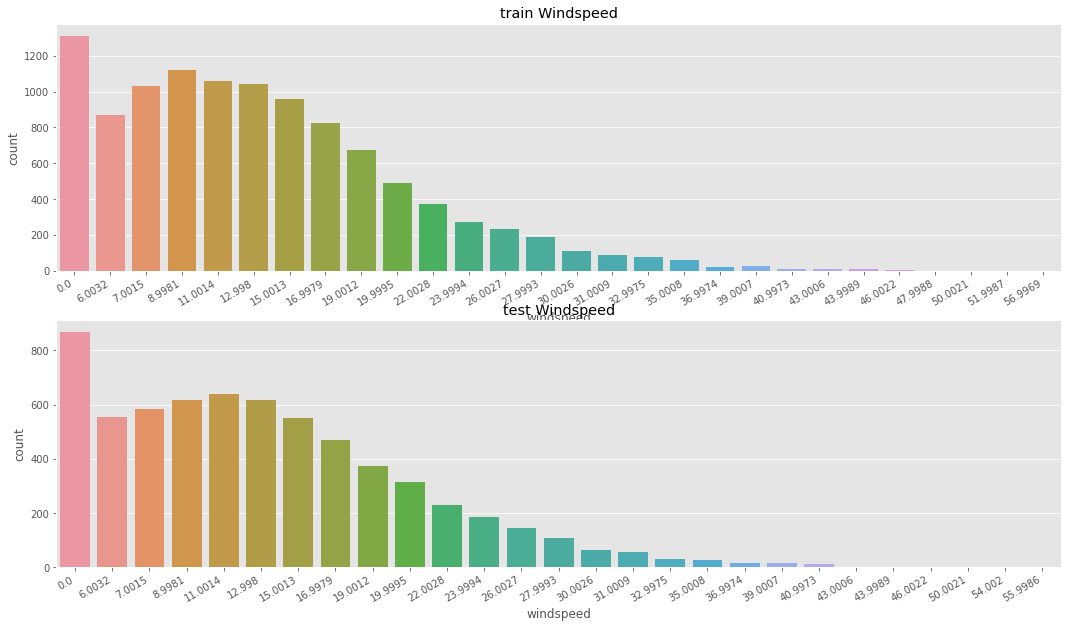

In [5]:
fig, axes = plt.subplots(nrows=2, figsize=(18, 10))

plt.sca(axes[0])
plt.xticks(rotation=30, ha="right")
axes[0].set(ylabel="Count", title="train Windspeed")
sns.countplot(data=df_train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha="right")
axes[1].set(ylabel="Count", title="test Windspeed")
sns.countplot(data=df_test, x="windspeed", ax=axes[1])

#### 풍속에 특정 값 넣어주기

In [6]:
trainWind0 = df_train.loc[df_train["windspeed"] == 0]
trainWindNot0 = df_train.loc[df_train["windspeed"] != 0]

print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [7]:
# 머신러닝으로 예측해 풍속 넣어주기

from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인 것과 아닌 것으로 나누기
    dataWind0 = data.loc[data["windspeed"] == 0]
    dataWindNot0 = data.loc[data["windspeed"] != 0]
    
    # 풍속 예측할 feature 선택
    wcol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]
    
    # 풍속이 0이 아닌 데이터 타입을 str로 변경
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
    
    # 랜덤포레스트 분류기 이용
    rfModel_wind = RandomForestClassifier()
    
    # wcol에 있는 feature값 바탕으로 풍속 학습
    rfModel_wind.fit(dataWindNot0[wcol], dataWindNot0["windspeed"])
    
    # 학습한 값 바탕으로 풍속=0인 데이터의 풍속 예측
    wind0Values = rfModel_wind.predict(X=dataWind0[wcol])
    
    # 값 모두 예측 후 비교하기 위해 예측한 값 넣어줄 데이터 프레임 새로 만들기
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    # 값이 0으로 기록된 풍속에 대해 예측한 값 넣어주기
    predictWind0["windspeed"] = wind0Values
    
    # 0이 아닌 풍속의 데이터에 예측한 값이 있는 데이터 합쳐주기
    data = predictWindNot0.append(predictWind0)
    
    # 풍속 데이터 타입을 float로 지정하기
    data["windspeed"] = data["windspeed"].astype("float")
    
    data.reset_index(inplace=True)
    data.drop("index", inplace=True, axis=1)
    
    return data

<AxesSubplot:title={'center':'train Windspeed'}, xlabel='windspeed', ylabel='count'>

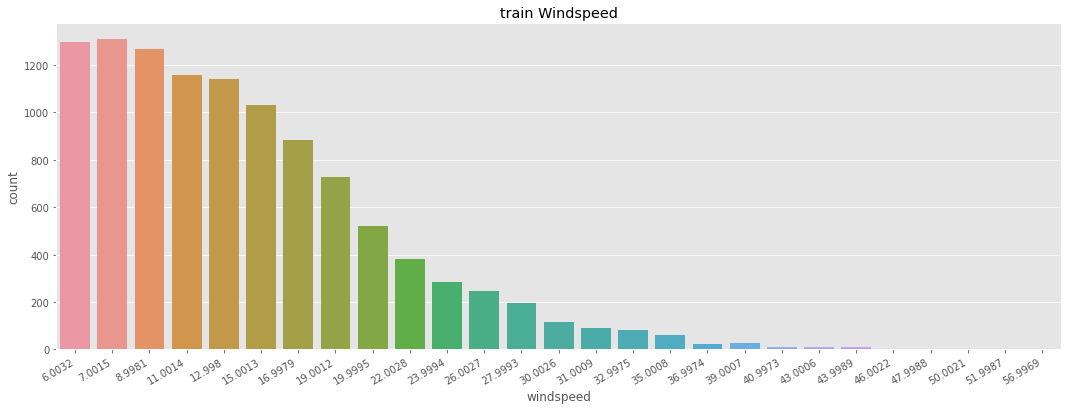

In [8]:
# 풍속=0인 값 조정해주기
df_train = predict_windspeed(df_train)

# 시각화
fig, ax1 = plt.subplots(figsize=(18, 6))

plt.sca(ax1)
plt.xticks(rotation=30, ha="right")
ax1.set(ylabel='Count',title="train Windspeed")
sns.countplot(data=df_train, x="windspeed", ax=ax1)

# Feature Selection

- feature들 추가하고 변경해가며 성능이 좋지 않은 feature는 제거하기

In [9]:
categorical_feature_names = ["season", "holiday", "workingday",
                             "weather", "weekday", "month",
                             "year", "hour"]

for var in categorical_feature_names:
    df_train[var] = df_train[var].astype("category")
    df_test[var] = df_test[var].astype("category")

In [10]:
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                "windspeed", "year", "hour", "weekday", "holiday",
                "workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'weekday',
 'holiday',
 'workingday']

In [11]:
X_train = df_train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,weekday,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [12]:
X_test = df_test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,weekday,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


- 우리가 찾아야 할 count 값은 label로 따로 떼기

In [13]:
label_name = "count"

y_train = df_train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# Score

## RMSLE

- 오차를 제곱해 평균한 값의 제곱근
- 값이 작을수록(0에 가까울수록) 정밀도가 높다.

$$
\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
$$

- 값이 작을수록 오류가 작다.

In [14]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값, 실제값에 +1하고 로그를 씌우기
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # (예측값 - 실제값)의 제곱
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균
    mean_difference = difference.mean()
    
    # 루트
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## Cross Validation (교차 검증)

- 일반화 성능을 측정하기 위해 데이터를 여러 번 반복해서 나누고 여러 모델 학습하기


#### KFold 교차검증
- 데이터를 '폴드'라 부른느 비슷한 크기의 부분집합(n_splits)으로 나누고, 각각의 폴드 정확도를 측정함
- 첫 번째 폴드를 test set로 사용하고, 나머지 폴드를 train set으로 사용
- 나머지 train set으로 만들어진 set의 정확도를 첫 번재 폴드로 평가
- 다음 두 번째 폴드가 test set이 되고, 나머지 폴드의 train set을 두 번째 폴드로 정확도 측정
- 이 과정을 마지막 폴드까지 반복


- 이렇게 train set와 test set으로 나누는 N개의 분할마다 정확도를 측정하여 평균 값을 낸게 정확도가 됨

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## RandomForest

In [16]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                             n_jobs=1,
                             random_state=0)
model

RandomForestRegressor(n_jobs=1, random_state=0)

In [17]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)

score = score.mean()

# 0에 근접할수록 좋은 데이터
print("Score = {0:.5f}".format(score))

CPU times: user 35.7 s, sys: 52.9 ms, total: 35.7 s
Wall time: 35.8 s
Score = 0.33103


# Train

In [18]:
# feature와 label을 넣어주면 알아서 학습함

model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=1, random_state=0)

In [19]:
# 예측

predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.4 ,   5.12,   4.17,   3.48,   3.13,   6.05,  38.36, 105.22,
       237.53, 137.25])

[Text(0.5, 1.0, 'df_test')]

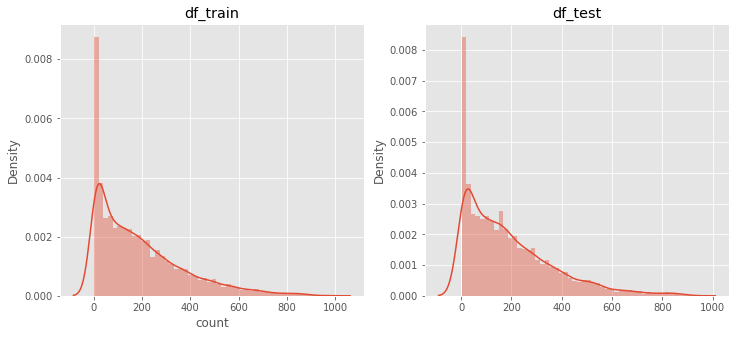

In [20]:
# 예측한 데이터 시각화

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title="df_train")

sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title="df_test")

# Submit

In [21]:
submission = pd.read_csv("../input/bike-sharing-demand/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.40
1,2011-01-20 01:00:00,5.12
2,2011-01-20 02:00:00,4.17
3,2011-01-20 03:00:00,3.48
4,2011-01-20 04:00:00,3.13


In [22]:
submission.to_csv("Score_{0:.5f}_submission.csv".format(score), index=False)